In [1]:
from data_loader import dataloader
import os
import re
import pickle
import hashlib
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from os.path import isfile, isdir
from urllib.request import urlretrieve
from tensorflow.python.ops import math_ops
from sklearn.model_selection import train_test_split

In [2]:
tf.__version__

'2.8.0'

PREPROCESSING

In [3]:
user,ratings,movies = dataloader()
print(user.head())
print(movies.head())
print(ratings.head())

   user_id gender  age  occupation    zip
0        1      F    1          10  48067
1        2      M   56          16  70072
2        3      M   25          15  55117
3        4      M   45           7  02460
4        5      M   25          20  55455
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291


In [4]:
ratings = ratings.filter(regex=('user_id|movie_id|rating'))
print(ratings)

         user_id  movie_id  rating
0              1      1193       5
1              1       661       3
2              1       914       3
3              1      3408       4
4              1      2355       5
...          ...       ...     ...
1000204     6040      1091       1
1000205     6040      1094       5
1000206     6040       562       5
1000207     6040      1096       4
1000208     6040      1097       4

[1000209 rows x 3 columns]


In [5]:
n_users = len(ratings.user_id.unique())
n_movies = len(ratings.movie_id.unique())
print("No of unique users:", n_users)
print("No of unique movies: ", n_movies, "\n")

No of unique users: 6040
No of unique movies:  3706 



In [6]:
gender_map = {'F':0, 'M':1}
user['gender'] = user['gender'].map(gender_map)
age_map = {val:idx for idx, val in enumerate(set(user['age']))}
user['age'] = user['age'].map(age_map)
users = user.filter(regex='user_id|gender|age|occupation')
users['user_inf'] = users.apply(lambda x: list([x['gender'],
                                        x['age'],
                                        x['occupation']]),axis=1) 
user_map = {}
for i in range(len(users['user_id'])):
    k = {users.iloc[i]['user_id']: np.array(users.iloc[i]['user_inf'])}
    user_map.update(k)

In [7]:
ratings['user_inf'] = ratings.loc[:, 'user_id']
ratings['user_inf'] = ratings['user_inf'].map(user_map)
ratings

,user_id,movie_id,rating,user_inf
0,1,1193,5,"[0, 0, 10]"
1,1,661,3,"[0, 0, 10]"
2,1,914,3,"[0, 0, 10]"
3,1,3408,4,"[0, 0, 10]"
4,1,2355,5,"[0, 0, 10]"
...,...,...,...,...
1000204,6040,1091,1,"[1, 6, 6]"
1000205,6040,1094,5,"[1, 6, 6]"
1000206,6040,562,5,"[1, 6, 6]"
1000207,6040,1096,4,"[1, 6, 6]"


In [8]:
genres_set = set()
for val in movies['genres'].str.split('|'):
    genres_set.update(val)
genres_set = list(genres_set)
genre_index_by_name = {name:i for i, name in enumerate(genres_set)}
print(genre_index_by_name)
# print(type(movie_index_by_id[1]))
movies_map = {}
movie_features = np.zeros((len(movies), len(genres_set)))
for i in range(len(movies)):
    for genre in movies.iloc[i]['genres'].split("|"):        
        genre_index = genre_index_by_name[genre]
        movie_features[i, genre_index] = 1
    k = {movies.iloc[i]['movie_id']: movie_features[i]}
    movies_map.update(k)

{'Thriller': 0, 'Crime': 1, "Children's": 2, 'Fantasy': 3, 'Musical': 4, 'Comedy': 5, 'Horror': 6, 'Documentary': 7, 'Western': 8, 'Animation': 9, 'Action': 10, 'Mystery': 11, 'Drama': 12, 'Adventure': 13, 'War': 14, 'Film-Noir': 15, 'Romance': 16, 'Sci-Fi': 17}


In [9]:
ratings['movie_inf'] = ratings.loc[:, 'movie_id']
ratings['movie_inf'] = ratings['movie_inf'].map(movies_map)
ratings

,user_id,movie_id,rating,user_inf,movie_inf
0,1,1193,5,"[0, 0, 10]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,661,3,"[0, 0, 10]","[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,914,3,"[0, 0, 10]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,3408,4,"[0, 0, 10]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,2355,5,"[0, 0, 10]","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
1000204,6040,1091,1,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1000205,6040,1094,5,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1000206,6040,562,5,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1000207,6040,1096,4,"[1, 6, 6]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


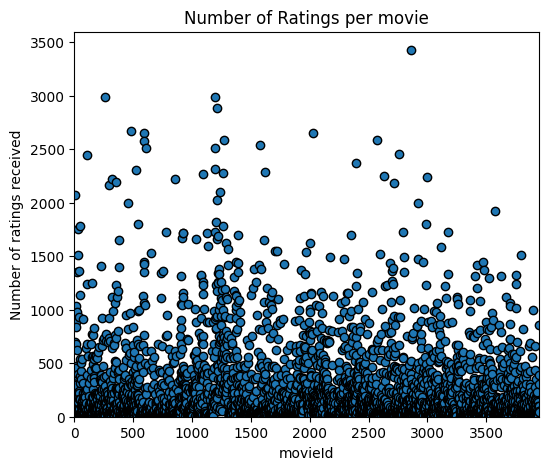

In [10]:
import matplotlib.pyplot as plt
rating_count = ratings[['movie_id','rating']].groupby(['movie_id']).count()
plt.figure(figsize=(6,5))
plt.scatter(rating_count.index, rating_count.rating, edgecolor='black')
plt.xlim(0,rating_count.index.max())
plt.ylim(0,)
plt.title('Number of Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

In [11]:
train, test = train_test_split(ratings, test_size= 0.2, random_state= 42)

NEURAL NETWORK BUILDING

In [12]:
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
import tensorflow as tf
     
#Creating movie embedding path
movie_input = Input(shape = (1,), name = "Movie-Input")
movie_embedding = Embedding(n_movies + 1, 10, name= "Movie-Embedding")(movie_input)
movie_vec = Flatten(name = "Flatten-Movies")(movie_embedding)

#Creating user embedding path
user_input = Input(shape = (1,), name = "User-Input")
user_embedding = Embedding(n_users + 1, 10, name = "User-Embedding")(user_input)
user_vec = Flatten(name = "Flatten-Users")(user_embedding)

#creating movie_inf embedding path
genres_input = Input(shape = (18,), name = "Genres-Input")
genres_embedding = Embedding(18, 5, name = "Genres-Embedding")(genres_input)
genres_vec = Flatten(name = "Flatten-Genres")(genres_embedding)


# Creating user_inf path
user_inf_input = Input(shape = (3,), name = "User_inf-Input")
# tf.convert_to_tensor(user_inf_input)
# user_inf_embedding = Embedding(n_users + 1, 10, name = "User_inf-Embedding")(user_inf_input)
user_inf_vec = Flatten(name = "Flatten_inf-Users")(user_inf_input)

#Concatenate features
conc = Concatenate()([movie_vec, user_vec, user_inf_vec, genres_vec])

#Weight Initialization
initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1., seed = None)

#Add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(100, activation='relu')(fc1)
fc3 = Dense(80, activation='relu')(fc2)
fc4 = Dense(60, activation='relu')(fc3)
fc5 = Dense(32, activation='relu')(fc4)
out = Dense(1)(fc5)

#Create model and compile it
model = Model([[user_input, movie_input], user_inf_input,genres_input], out)
model.compile('adam', 'mean_squared_error')

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Movie-Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Genres-Input (InputLayer)      [(None, 18)]         0           []                               
                                                                                                  
 Movie-Embedding (Embedding)    (None, 1, 10)        37070       ['Movie-Input[0][0]']            
                                                                                              

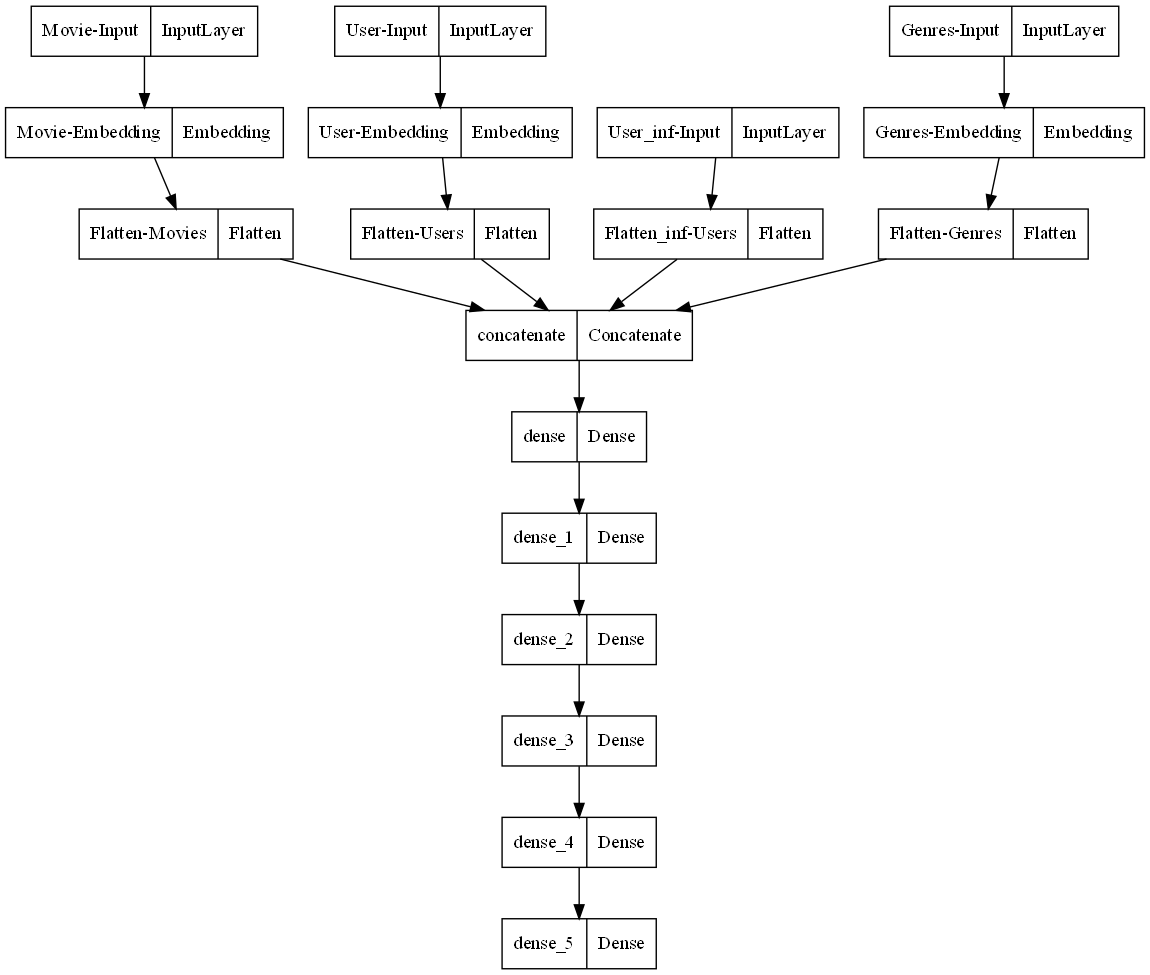

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model, rankdir= 'TR', dpi = 100)

In [15]:
[print(i.shape, i.dtype) for i in model.inputs]

(None, 1) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
(None, 3) <dtype: 'float32'>
(None, 18) <dtype: 'float32'>


[None, None, None, None]

In [16]:
train.user_inf

416292     [1, 6, 4]
683230     [1, 0, 4]
2434      [1, 0, 10]
688533     [1, 6, 3]
472584     [0, 1, 5]
             ...    
259178     [1, 2, 7]
365838     [1, 6, 5]
131932    [0, 6, 16]
671155     [1, 6, 6]
121958     [1, 6, 0]
Name: user_inf, Length: 800167, dtype: object

In [17]:
np.array([np.array(val) for val in train.user_inf]).shape
np.array([np.array(val) for val in train.movie_inf]).shape

(800167, 18)

In [18]:
train.movie_id.shape

(800167,)

In [19]:
history = model.fit([[train.user_id, train.movie_id],np.array([np.array(val) for val in train.user_inf]), np.array([np.array(val) for val in train.movie_inf])], train.rating, epochs = 18, verbose = 1)

Epoch 1/18
25006/25006 [==============================] - 165s 7ms/step - loss: 0.8838
Epoch 2/18
25006/25006 [==============================] - 164s 7ms/step - loss: 0.8136
Epoch 3/18
25006/25006 [==============================] - 159s 6ms/step - loss: 0.7906
Epoch 4/18
25006/25006 [==============================] - 157s 6ms/step - loss: 0.7650
Epoch 5/18
25006/25006 [==============================] - 157s 6ms/step - loss: 0.7451
Epoch 6/18
25006/25006 [==============================] - 163s 7ms/step - loss: 0.7294
Epoch 7/18
25006/25006 [==============================] - 173s 7ms/step - loss: 0.7159
Epoch 8/18
25006/25006 [==============================] - 174s 7ms/step - loss: 0.7051
Epoch 9/18
25006/25006 [==============================] - 178s 7ms/step - loss: 0.6963
Epoch 10/18
25006/25006 [==============================] - 178s 7ms/step - loss: 0.6887
Epoch 11/18
25006/25006 [==============================] - 175s 7ms/step - loss: 0.6820
Epoch 12/18
25006/25006 [================

In [20]:
model.save('Neural_RS')

INFO:tensorflow:Assets written to: Neural_RS\assets


INFO:tensorflow:Assets written to: Neural_RS\assets


In [21]:
from keras.models import load_model
model = load_model("Neural_RS")

In [32]:
item_data = np.array(list(set(ratings.movie_id)))
item_data[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [33]:
user = np.array([1 for i in range(len(item_data))])
user[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [36]:
user_inf_pre = np.array([np.array([0, 0, 10]) for i in range(len(item_data))])
user_inf_pre

array([[ 0,  0, 10],
       [ 0,  0, 10],
       [ 0,  0, 10],
       ...,
       [ 0,  0, 10],
       [ 0,  0, 10],
       [ 0,  0, 10]])

In [37]:
train.movie_inf[1]

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [42]:
movie_inf_pre = np.array([np.array(movies_map[i]) for i in item_data])
movie_inf_pre



array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [43]:
predictions = model.predict([[user,item_data],user_inf_pre,movie_inf_pre])
predictions

array([[4.3937063],
       [3.3985052],
       [3.8286796],
       ...,
       [3.686586 ],
       [3.686586 ],
       [3.6169138]], dtype=float32)

In [44]:
predictions = np.array([a[0] for a in predictions])
recommended_movie = predictions[::-1].argsort()[:10]
recommended_movie


array([ 368,  282,  283,  253,  284,  892,  252, 2479, 2672,  285],
      dtype=int64)

In [45]:
movies[movies['movie_id'].isin(recommended_movie)]

,movie_id,title,genres
249,252,I.Q. (1994),Comedy|Romance
250,253,Interview with the Vampire (1994),Drama|Horror
279,282,Nell (1994),Drama
280,283,New Jersey Drive (1995),Crime|Drama
281,284,New York Cop (1996),Action|Crime
282,285,Beyond Bedlam (1993),Drama|Horror
364,368,Maverick (1994),Action|Comedy|Western
880,892,Twelfth Night (1996),Comedy|Drama|Romance
2410,2479,Gloria (1999),Drama|Thriller
2603,2672,"Thirteenth Floor, The (1999)",Drama|Sci-Fi|Thriller


In [46]:
model.evaluate([[test.user_id, test.movie_id], np.array([np.array(val) for val in test.user_inf]), np.array([np.array(val) for val in test.movie_inf]) ], test.rating)

6252/6252 [==============================] - 22s 4ms/step - loss: 0.7659


0.765880823135376